# Importing Libraries 


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import optim,nn
from torch.utils.data.dataset import Dataset
from torchvision import transforms 
from export import load_cifar10_data
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms


# Model Archietechture 

In [14]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=256):
        super(Encoder, self).__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x32 -> 16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16 -> 8x8

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # 8x8 -> 4x4
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256*4*4, latent_dim)

    def forward(self, x):
        x = self.conv_op(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [15]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=256, out_channels=3):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256*4*4)
        self.conv_op = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), # 4x4 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), # 8x8 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2), # 16x16 -> 32x32
            nn.Sigmoid() # Pixel values in range [0, 1]
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 4, 4)
        x = self.conv_op(x)
        return x


In [16]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channles=3,latent_dim=256):
        super(AutoEncoder,self).__init__()
        self.encoder=Encoder(in_channles,latent_dim)
        self.decoder=Decoder(latent_dim,in_channles)
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x

In [17]:
if (torch.cuda.is_available):
    device="cuda"
    if device=="cuda":
        num_workers=torch.cuda.device_count() * 1
        print(num_workers)
        print(torch.cuda.get_device_name())
else:
    print("cuda is not availabel")
    device= "cpu"

1
NVIDIA RTX A5000


# Data Loding 

In [18]:
(train_images, train_labels), (test_images, test_labels), class_names = load_cifar10_data()

print(f"Training Data: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Test Data: {test_images.shape}, Labels: {test_labels.shape}")
print(f"Class Names: {class_names}")

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10Dataset(train_images, train_labels, transform=transform)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train loader: {train_loader}")
print(f"Test loader: {test_loader}")


Training Data: (50000, 32, 32, 3), Labels: (50000,)
Test Data: (10000, 32, 32, 3), Labels: (10000,)
Class Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train loader: <torch.utils.data.dataloader.DataLoader object at 0x783c38095ed0>
Test loader: <torch.utils.data.dataloader.DataLoader object at 0x783c38991e90>


# Initilizing the model 

In [19]:
model=AutoEncoder(in_channles=3,latent_dim=256)
loss_function=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-8)

# Training Model

In [20]:
epochs = 20
losses = []
val_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()  # Set model to training mode
    for batch_idx, (images, _) in enumerate(train_loader):  
        images = images.to(device, dtype=torch.float32)  

        output = model(images)
        loss = loss_function(output, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Print loss every 100 batches
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Validation Step (Tracking steps)
    model.eval()  
    val_loss = 0.0
    with torch.no_grad():  
        for val_batch_idx, (val_images, _) in enumerate(test_loader):  
            val_images = val_images.to(device, dtype=torch.float32)  
            val_output = model(val_images)
            batch_val_loss = loss_function(val_output, val_images).item()
            val_loss += batch_val_loss  # Accumulate loss
            
            # Print validation loss every 100 batches
            if val_batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Val Step [{val_batch_idx}/{len(test_loader)}], Batch Val Loss: {batch_val_loss:.4f}")

    val_loss /= len(test_loader)  # Get average validation loss
    val_losses.append(val_loss)  
    print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}")

# **Save final model checkpoint after training**
final_model_path = "autoencoder_final.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Final trained model saved at: {final_model_path}")

print("Training Complete!")


Epoch [1/20], Step [0/1563], Loss: 0.5436
Epoch [1/20], Step [100/1563], Loss: 0.2497
Epoch [1/20], Step [200/1563], Loss: 0.2350
Epoch [1/20], Step [300/1563], Loss: 0.1592
Epoch [1/20], Step [400/1563], Loss: 0.1691
Epoch [1/20], Step [500/1563], Loss: 0.1552
Epoch [1/20], Step [600/1563], Loss: 0.1703
Epoch [1/20], Step [700/1563], Loss: 0.1703
Epoch [1/20], Step [800/1563], Loss: 0.1516
Epoch [1/20], Step [900/1563], Loss: 0.1579
Epoch [1/20], Step [1000/1563], Loss: 0.1472
Epoch [1/20], Step [1100/1563], Loss: 0.1502
Epoch [1/20], Step [1200/1563], Loss: 0.1313
Epoch [1/20], Step [1300/1563], Loss: 0.1457
Epoch [1/20], Step [1400/1563], Loss: 0.1294
Epoch [1/20], Step [1500/1563], Loss: 0.1418
Epoch [1/20], Val Step [0/313], Batch Val Loss: 0.1676
Epoch [1/20], Val Step [100/313], Batch Val Loss: 0.1681
Epoch [1/20], Val Step [200/313], Batch Val Loss: 0.1359
Epoch [1/20], Val Step [300/313], Batch Val Loss: 0.1478
Epoch [1/20], Validation Loss: 0.1543
Epoch [2/20], Step [0/1563],

# Evaluating Different Score of test data


In [21]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch.nn.functional as F

# Ensure evaluation mode
model.eval()

# Get test images and reconstructed images
test_images, _ = next(iter(test_loader))  # Fetch a batch from test_loader
test_images = test_images.to(device)

with torch.no_grad():
    reconstructed_images = model(test_images)

# Convert tensors to numpy for evaluation
test_images_np = test_images.cpu().detach().numpy()
reconstructed_images_np = reconstructed_images.cpu().detach().numpy()

# Function to evaluate reconstruction quality
def evaluate_reconstruction(original, reconstructed):
    batch_size = original.shape[0]
    ssim_scores, psnr_scores, mae_scores, mse_scores = [], [], [], []

    for i in range(batch_size):
        orig = np.transpose(original[i], (1, 2, 0))  # Convert (C, H, W) → (H, W, C)
        recon = np.transpose(reconstructed[i], (1, 2, 0))

        ssim_scores.append(ssim(orig, recon, channel_axis=-1, data_range=1.0, win_size=3))
        psnr_scores.append(psnr(orig, recon, data_range=1.0))
        mae_scores.append(np.mean(np.abs(orig - recon)))
        mse_scores.append(np.mean((orig - recon) ** 2))

    return {
        "SSIM": np.mean(ssim_scores),
        "PSNR": np.mean(psnr_scores),
        "MAE": np.mean(mae_scores),
        "MSE": np.mean(mse_scores),
    }

# Get the evaluation results
metrics = evaluate_reconstruction(test_images_np, reconstructed_images_np)
print("Evaluation Results:", metrics)

Evaluation Results: {'SSIM': 0.23389441, 'PSNR': 8.938674363215792, 'MAE': 0.28560546, 'MSE': 0.15566076}


# Getting Latent vectors 

In [22]:
# Get the latent representations of the test images
model.eval()  # Set model to evaluation mode
latent_vectors = []

with torch.no_grad():  # No need to compute gradients
    for images, _ in test_loader:  # Assuming test_loader is defined
        images = images.to(device, dtype=torch.float32)
        latent = model.encoder(images)  # Get the latent representation
        latent_vectors.append(latent.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0)  # Combine all batches into one tensor

print(f"Latent space shape: {latent_vectors.shape}")  # Check shape


Latent space shape: torch.Size([10000, 256])


# Visualizing Latent Space 

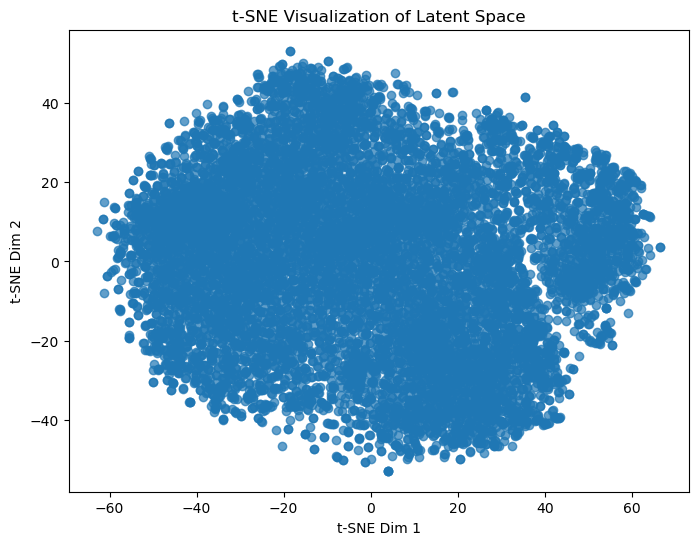

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Convert latent representations to NumPy
latent_representations = latent_vectors.cpu().detach().numpy()

# Step 1: Reduce to 50 dimensions using PCA (if latent dim > 50)
pca = PCA(n_components=min(50, latent_representations.shape[1]))  
latent_pca = pca.fit_transform(latent_representations)

# Step 2: Apply t-SNE to project down to 2D
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_pca)

# Plot t-SNE visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], alpha=0.7)
plt.title("t-SNE Visualization of Latent Space")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()


# Visualization 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.654902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input d

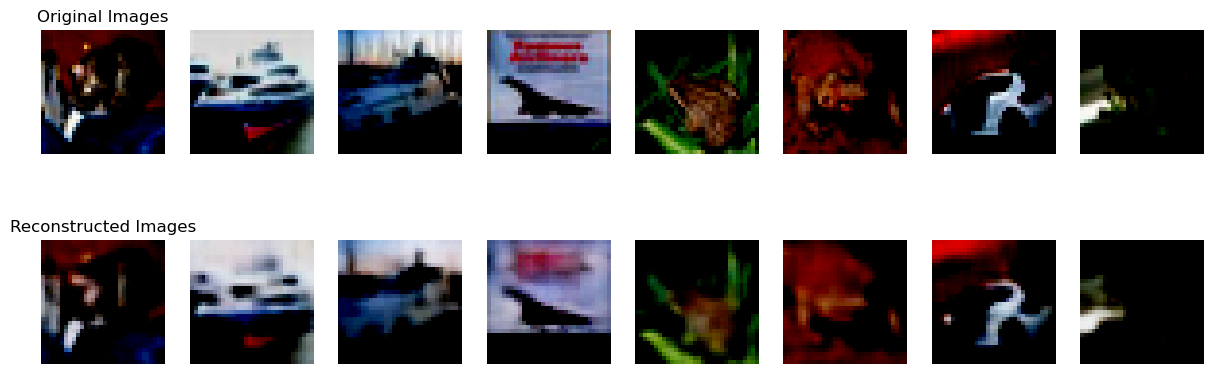

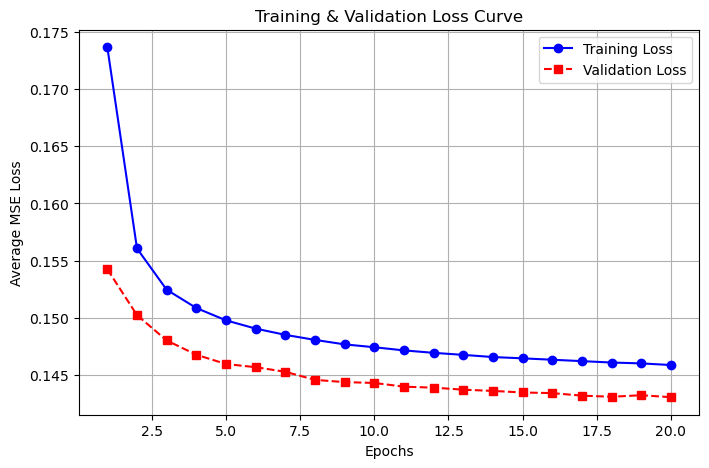

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to visualize original vs. reconstructed images
def visualize_reconstruction(model, test_loader, num_images=8):
    model.eval()
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))

    with torch.no_grad():
        images, _ = next(iter(test_loader))  # Get a batch of test images
        images = images.to(device)
        reconstructed = model(images)  # Pass through Autoencoder

    images = images.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()

    for i in range(num_images):
        # Original image
        axes[0, i].imshow(np.transpose(images[i], (1, 2, 0)))  # (C, H, W) → (H, W, C)
        axes[0, i].axis('off')

        # Reconstructed image
        axes[1, i].imshow(np.transpose(reconstructed[i], (1, 2, 0)))
        axes[1, i].axis('off')

    axes[0, 0].set_title("Original Images")
    axes[1, 0].set_title("Reconstructed Images")
    plt.show()


# Function to plot Training Loss and Validation Loss per Epoch
def plot_loss_curve(train_losses, val_losses, epochs):
    train_avg_loss = np.array(train_losses).reshape(epochs, -1).mean(axis=1)  # Avg training loss per epoch
    val_avg_loss = np.array(val_losses)  # Already stored per epoch

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_avg_loss, marker='o', linestyle='-', color='b', label="Training Loss")
    plt.plot(range(1, epochs + 1), val_avg_loss, marker='s', linestyle='--', color='r', label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Average MSE Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()


# Call the functions after training
visualize_reconstruction(model, test_loader)
plot_loss_curve(losses, val_losses, epochs)
